# Semantic segmentation using Poutyne

Semantic segmentation refers to the process of linking each pixel in an image to a class label. We can think of semantic segmentation as image classification at a pixel level. The image below clarifies the definition of semantic segmentation.

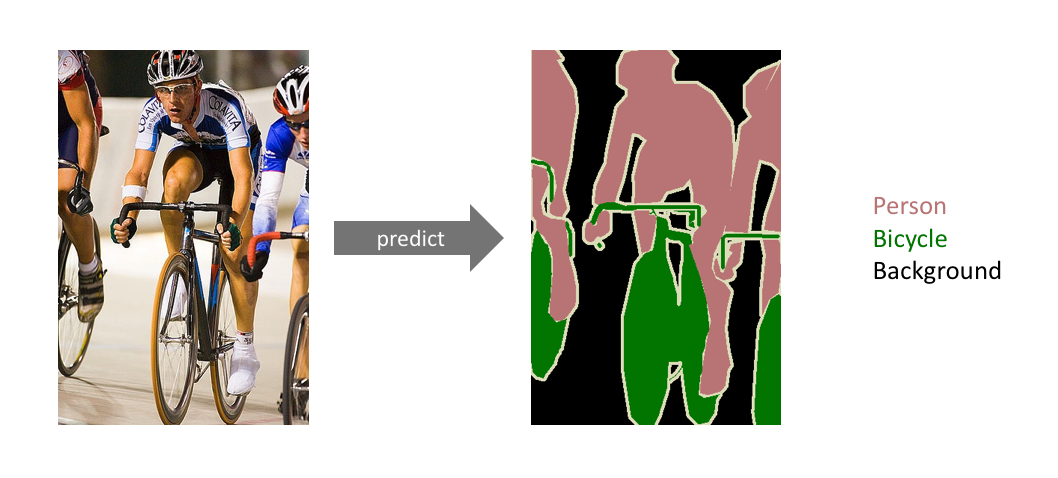

<a href="https://www.jeremyjordan.me/semantic-segmentation/"> Source</a>

In this example, we will use and train a convolutional U-Net to design a network for semantic segmentation. In other words, we formulate the task of semantic segmentation as an image translation problem. We download and use the VOCSegmentation 2007 dataset for this purpose.

In [1]:
%pip install poutyne    # Installing the Poutyne library

Note: you may need to restart the kernel to use updated packages.


U-Net is a convolutional neural network similar to convolutional autoencoders. However, U-Net takes advantage of shortcuts between the encoder (contraction path) and decoder (expanding path), which helps it handle the vanishing gradient problem. In the following sections, we will install and import the segmentation-models-Pytorch library, which contains different U-Net architectures.

In [2]:
%pip install segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.


Let’s import all the needed packages and define some useful functions.

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms.functional import InterpolationMode
import segmentation_models_pytorch as smp
import torchmetrics
from poutyne import Model, ModelCheckpoint, CSVLogger, set_seeds
from torch.utils.data import DataLoader
from PIL import Image


def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor


def plot_images(images, num_per_row=8, title=None):
    num_rows = int(math.ceil(len(images) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row, dpi=150)
    fig.subplots_adjust(wspace=0, hspace=0)

    for image, ax in zip(images, axes.flat):
        ax.imshow(image)
        ax.axis('off')

    return fig


# Color palette for segmentation masks
PALETTE = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)


def array1d_to_pil_image(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

## Training constants

In [4]:
learning_rate = 0.0005
batch_size = 32
image_size = 224
num_epochs = 70
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the imagenet dataset for normalizing
imagenet_std = [0.229, 0.224, 0.225]  # std of the imagenet dataset for normalizing
set_seeds(43)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)

The current processor is ... cuda


## Loading the VOCSegmentation dataset

The VOCSegmentation dataset can be easily downloaded from `torchvision.datasets`. This dataset allows you to apply the needed transformations on the ground-truth directly and define the proper transformations for the input images. To do so, we use the `target_transfrom` argument and set it to your transformation function of interest.

In [5]:
input_resize = transforms.Resize((224, 224))
input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

target_resize = transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST)
target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)),
    ]
)

# Creating the dataset
train_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    download=True,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)
valid_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    download=True,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)
test_dataset = datasets.VOCSegmentation(
    './data/VOC/',
    year='2007',
    download=True,
    image_set='test',
    transform=input_transform,
    target_transform=target_transform,
)

# Creating the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## A random batch of the VODSegmentation dataset images

Let's see some of the input samples inside the training dataset

In [6]:
# Creating a VOC dataset without normalization for visualization.
train_dataset_viz = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    image_set='train',
    transform=input_resize,
    target_transform=target_resize,
)
inputs, ground_truths = map(list, zip(*[train_dataset_viz[i] for i in range(batch_size)]))

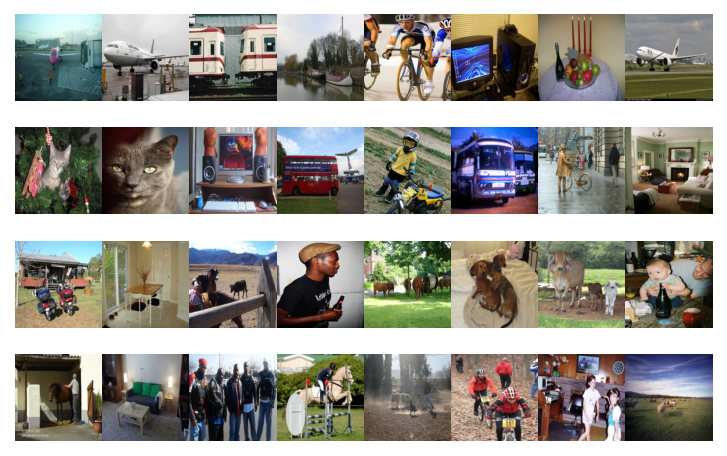

In [7]:
_ = plot_images(inputs)

The ground-truth (segmentation map) for the image grid shown above is as below. 

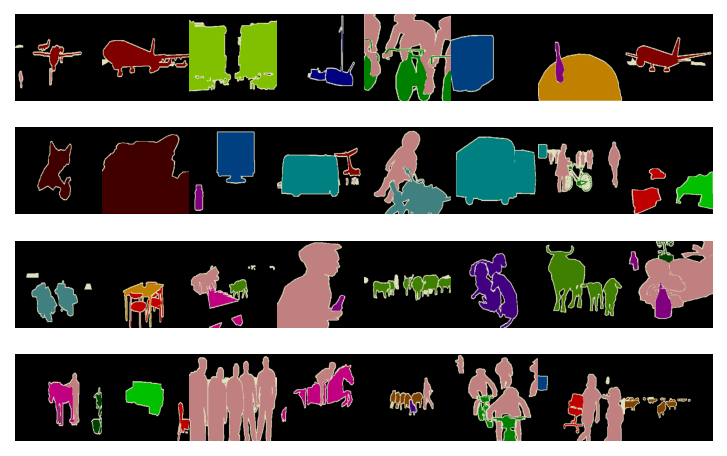

In [8]:
_ = plot_images(ground_truths)

It is worth mentioning that, as we have approached the segmentation task as an image translation problem, we use the cross-entropy loss for the training. Moreover, we believe that using the U-Net with a pre-trained encoder would help the network converge sooner and better. As this convolutional encoder is previously trained on the ImageNet, it is able to recognize low-level features (such as edge, color, etc.) and high-level features at its first and final layers, respectively.

In [9]:
# specifying loss function
criterion = nn.CrossEntropyLoss()

# specifying the network
network = smp.Unet('resnet34', encoder_weights='imagenet', classes=22)

# specifying optimizer
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

We can see the architecture of the ResNet-34-U-Net below. As noticed in the section above, this network is imported from the segmentation-models-pytorch library which contains many other architectures as well. You can import and use other available networks to try to increase the accuracy.

In [10]:
network

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Training deep neural networks is a challenging task, especially when we are dealing with data with big sizes or numbers. There are numerous factors and hyperparameters which play an important role in the success of the network. One of these determining factors is the number of epochs. The right number of epochs would help your network train well. However, lower and higher numbers would make your network underfit or overfit, respectively. With some data types (such as images or videos), it is very time-consuming to repeat the training for different numbers of epochs to find the best one. Poutyne library has provided some fascinating tools to address this problem. 

As you would notice in the following sections, by the use of <a href="https://poutyne.org/callbacks.html"> callbacks</a>, you would be able to record and retrieve the best parameters (weights) through your rather big number of epochs without needing to repeat the training process again and again. Moreover, Poutyne also gives you the possibility to resume your training from the last done epoch if you feel the need for even more iterations.

In [11]:
# callbacks

save_path = 'saves/unet-voc'

# Creating saving directory
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_weight.ckpt'),
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

## Training

For training, we use the Jaccard index metric in addition to the accuracy and F1-score. The Jaccard index is also kwown as IoU is a classical metric for semantic segmentation.

In [12]:
# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    criterion,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1', torchmetrics.JaccardIndex(num_classes=22, task="multiclass")],
    device=device,
)

# Train
_ = model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)

Epoch:  1/70 Train steps: 7 Val steps: 7 2.77s loss: 2.882121 acc: 23.082844 fscore_macro: 0.049921 jaccard_index: 0.028922 val_loss: 5.702050 val_acc: 6.758314 val_fscore_macro: 0.013619 val_jaccard_index: 0.007275
Epoch 1: val_loss improved from inf to 5.70205, saving file to saves/unet-voc/best_weight.ckpt
Epoch:  2/70 Train steps: 7 Val steps: 7 2.77s loss: 4.587334 acc: 51.362400 fscore_macro: 0.086979 jaccard_index: 0.059583 val_loss: 4.430934 val_acc: 28.868037 val_fscore_macro: 0.039326 val_jaccard_index: 0.023928
Epoch 2: val_loss improved from 5.70205 to 4.43093, saving file to saves/unet-voc/best_weight.ckpt
Epoch:  3/70 Train steps: 7 Val steps: 7 2.78s loss: 3.947988 acc: 58.392649 fscore_macro: 0.100909 jaccard_index: 0.071225 val_loss: 3.668791 val_acc: 44.129191 val_fscore_macro: 0.062700 val_jaccard_index: 0.042050
Epoch 3: val_loss improved from 4.43093 to 3.66879, saving file to saves/unet-voc/best_weight.ckpt
Epoch:  4/70 Train steps: 7 Val steps: 7 2.80s loss: 3.39

Epoch: 20/70 Train steps: 7 Val steps: 7 2.86s loss: 1.497345 acc: 82.656657 fscore_macro: 0.242232 jaccard_index: 0.196368 val_loss: 1.487946 val_acc: 73.945609 val_fscore_macro: 0.146141 val_jaccard_index: 0.107273
Epoch 20: val_loss improved from 1.52082 to 1.48795, saving file to saves/unet-voc/best_weight.ckpt
Epoch: 21/70 Train steps: 7 Val steps: 7 2.86s loss: 1.466563 acc: 82.486910 fscore_macro: 0.245866 jaccard_index: 0.196798 val_loss: 1.457593 val_acc: 74.836875 val_fscore_macro: 0.154749 val_jaccard_index: 0.113734
Epoch 21: val_loss improved from 1.48795 to 1.45759, saving file to saves/unet-voc/best_weight.ckpt
Epoch: 22/70 Train steps: 7 Val steps: 7 2.87s loss: 1.437044 acc: 83.294307 fscore_macro: 0.256471 jaccard_index: 0.207969 val_loss: 1.429053 val_acc: 73.765649 val_fscore_macro: 0.149898 val_jaccard_index: 0.108207
Epoch 22: val_loss improved from 1.45759 to 1.42905, saving file to saves/unet-voc/best_weight.ckpt
Epoch: 23/70 Train steps: 7 Val steps: 7 2.86s lo

Epoch: 39/70 Train steps: 7 Val steps: 7 2.87s loss: 1.169397 acc: 85.183933 fscore_macro: 0.381574 jaccard_index: 0.299824 val_loss: 1.171474 val_acc: 72.393934 val_fscore_macro: 0.155577 val_jaccard_index: 0.109834
Epoch 39: val_loss improved from 1.17806 to 1.17147, saving file to saves/unet-voc/best_weight.ckpt
Epoch: 40/70 Train steps: 7 Val steps: 7 2.85s loss: 1.163020 acc: 85.164596 fscore_macro: 0.399379 jaccard_index: 0.314344 val_loss: 1.169891 val_acc: 63.640493 val_fscore_macro: 0.112648 val_jaccard_index: 0.075798
Epoch 40: val_loss improved from 1.17147 to 1.16989, saving file to saves/unet-voc/best_weight.ckpt
Epoch: 41/70 Train steps: 7 Val steps: 7 2.87s loss: 1.162510 acc: 83.138196 fscore_macro: 0.328826 jaccard_index: 0.249332 val_loss: 1.165159 val_acc: 64.555796 val_fscore_macro: 0.137141 val_jaccard_index: 0.091492
Epoch 41: val_loss improved from 1.16989 to 1.16516, saving file to saves/unet-voc/best_weight.ckpt
Epoch: 42/70 Train steps: 7 Val steps: 7 2.84s lo

## Calculation of the scores and visualization of results

There is one more helpful feature in Poutyne, which makes the evaluation task more easy and straight forward. Usually, computer vision researchers try to evaluate their trained networks on validation/test datasets by obtaining the scores (accuracy or loss usually). The `evaluate` methods in Poutyne provides you the loss and the metrics. In the next few blocks of code, you will see some examples.

In [14]:
loss, (acc, f1, jaccard) = model.evaluate_generator(test_loader)

Test steps: 7 0.94s test_loss: 1.041243 test_acc: 71.989075 test_fscore_macro: 0.185714 test_jaccard_index: 0.124716


We show some of the segmentation results in the image below:

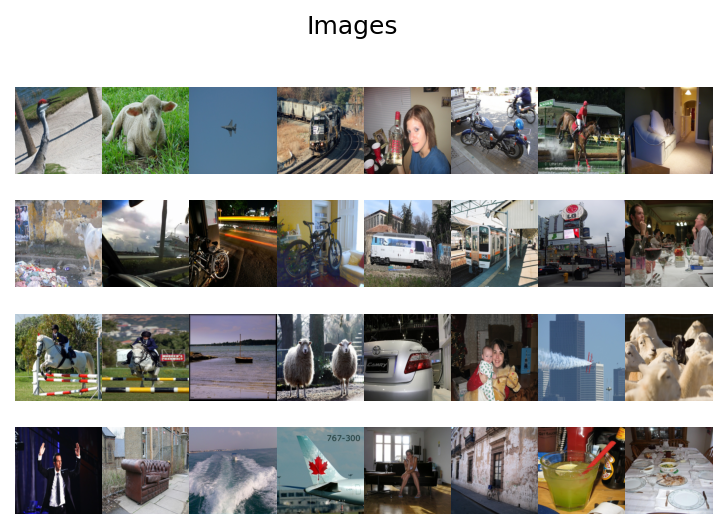

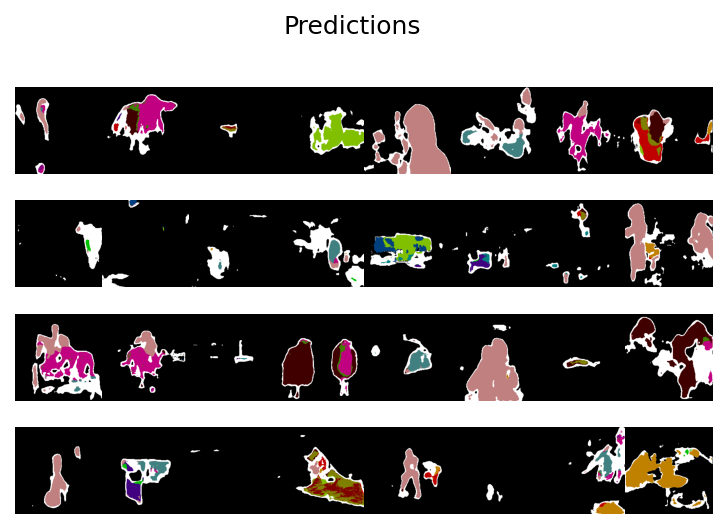

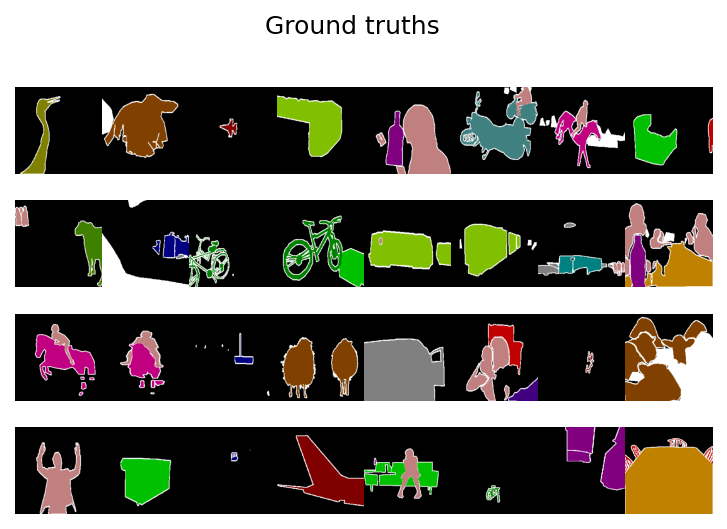

In [15]:
inputs, ground_truths = next(iter(test_loader))
outputs = model.predict_on_batch(inputs)
outputs = outputs.argmax(1)

outputs = replace_tensor_value_(outputs, 21, 255)
ground_truths = replace_tensor_value_(ground_truths, 21, 255)

plt_inputs = np.clip(inputs.numpy().transpose((0, 2, 3, 1)) * imagenet_std + imagenet_mean, 0, 1)
fig = plot_images(plt_inputs)
fig.suptitle("Images")

pil_outputs = [array1d_to_pil_image(out) for out in outputs]
fig = plot_images(pil_outputs)
fig.suptitle("Predictions")

pil_ground_truths = [array1d_to_pil_image(gt) for gt in ground_truths.numpy()]
fig = plot_images(pil_ground_truths)
_ = fig.suptitle("Ground truths")

## Last note

This example shows you how to design and train your own segmentation network simply. However, to get better results, you can play with the hyperparameters and do further finetuning to increase the accuracy.